In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

from pathlib import Path

from sklearn.cluster import DBSCAN

from PIL import Image
import cv2

from skimage.transform import resize

from scipy.ndimage import gaussian_filter

import os

from collections import defaultdict, deque
import shutil

In [2]:
image_path = "handwriting.jpg" 
image = Image.open(image_path)

In [3]:
width, height = image.size
width, height

(1600, 1150)

In [4]:
scaling_factor = 0.1
fig_width = width * scaling_factor
fig_height = height * scaling_factor

In [5]:
gray_image = image.convert("L")  # "L" mode converts the image to grayscale
gray_array = np.array(gray_image)

In [6]:
_, binary_image = cv2.threshold(gray_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [7]:
y_coords, x_coords = np.where(binary_image == 0)  # Dark pixels are represented by 0 in the binary image
coordinates = np.column_stack((x_coords, y_coords))

In [8]:
coordinates

array([[219, 359],
       [220, 359],
       [221, 359],
       ...,
       [285, 765],
       [286, 765],
       [287, 765]])

In [9]:
image = np.array(image)

In [10]:
db = DBSCAN(eps=2, min_samples=1).fit(coordinates)  # Adjust min_samples as needed
labels = db.labels_  # Get cluster labels for each point

In [11]:
cluster_coordinates = {}

In [12]:
plt.figure(figsize=(fig_width, fig_height))

unique_labels = set(labels)
n_clusters = len(unique_labels)

colors = [plt.cm.hsv(i / n_clusters) for i in range(n_clusters)]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise
    else:
        col = list(col)

    class_member_mask = (labels == k)
    xy = coordinates[class_member_mask]

    cluster_coordinates[k] = xy

    plt.scatter(xy[:, 0], xy[:, 1], color=tuple(col), label=f'Cluster {k}' if k != -1 else 'Noise')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:
print(cluster_coordinates)

{np.int64(0): array([[219, 359],
       [220, 359],
       [221, 359],
       ...,
       [285, 765],
       [286, 765],
       [287, 765]]), np.int64(1): array([[958, 448],
       [959, 448],
       [960, 448],
       [958, 449],
       [959, 449],
       [960, 449],
       [958, 450],
       [959, 450],
       [960, 450],
       [961, 450],
       [962, 450],
       [958, 451],
       [959, 451],
       [960, 451],
       [961, 451],
       [962, 451],
       [958, 452],
       [959, 452],
       [960, 452],
       [961, 452],
       [962, 452],
       [958, 453],
       [959, 453],
       [960, 453],
       [961, 453],
       [962, 453],
       [958, 454],
       [959, 454],
       [960, 454],
       [961, 454],
       [962, 454],
       [953, 455],
       [954, 455],
       [955, 455],
       [956, 455],
       [957, 455],
       [958, 455],
       [959, 455],
       [960, 455],
       [961, 455],
       [962, 455],
       [963, 455],
       [964, 455],
       [965, 455],
       [9

In [14]:
formatted_clusters = [
    [(int(point[0]), int(point[1])) for point in cluster]
    for cluster in cluster_coordinates.values()
]

# Print the formatted clusters
# for cluster in formatted_clusters:
#    print(cluster)

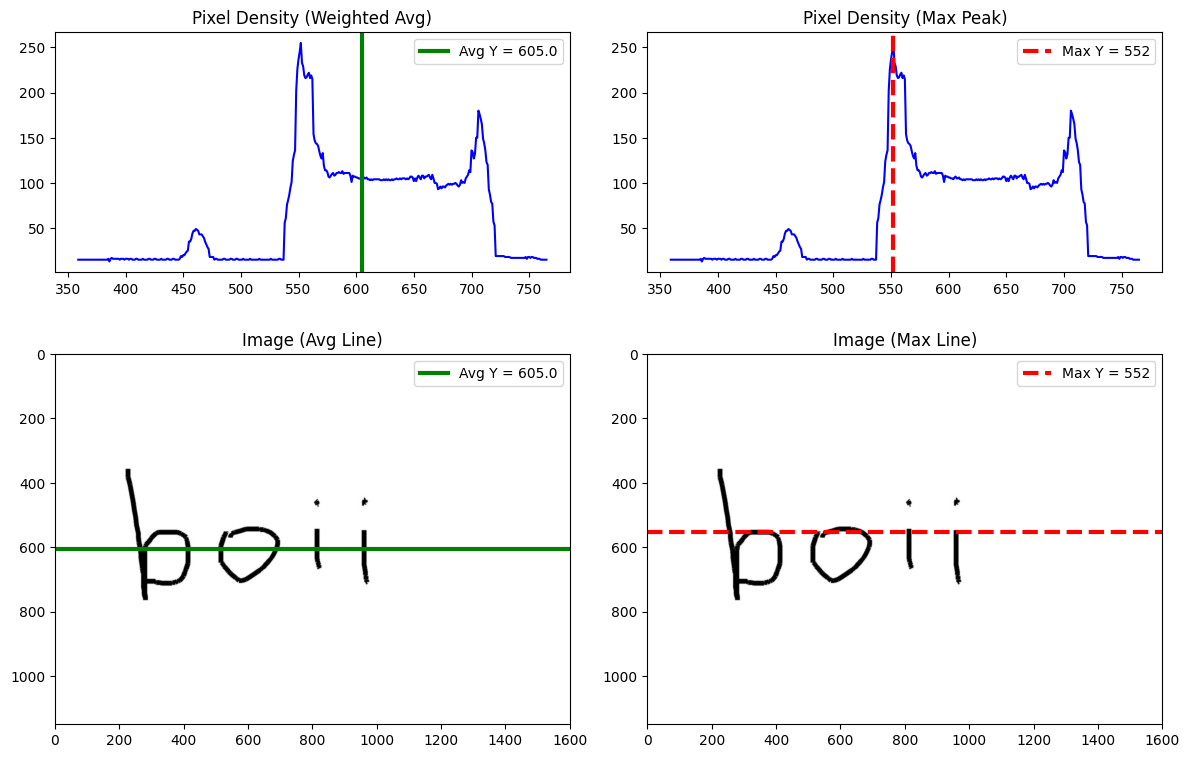

In [15]:
# Data Preparation
all_points = [pt for cluster in formatted_clusters for pt in cluster]
y_counts = defaultdict(int)
for _, y in all_points:
    y_counts[y] += 1

max_y = max(y_counts.items(), key=lambda item: item[1])[0]
avg_y = np.average(list(y_counts.keys()), weights=list(y_counts.values()))

# Plot Setup with Adjusted Height Ratios
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])

# Create subplots using the gridspec
ax1 = fig.add_subplot(gs[0, 0])  # Avg density
ax2 = fig.add_subplot(gs[0, 1])  # Max density
ax3 = fig.add_subplot(gs[1, 0])  # Image with avg line
ax4 = fig.add_subplot(gs[1, 1])  # Image with max line

# Top Row: Density Plots (Smaller Height)
ys_sorted = sorted(y_counts.keys())
counts_sorted = [y_counts[y] for y in ys_sorted]

# Plot 1: Avg Y-Density
ax1.plot(ys_sorted, counts_sorted, 'b-', linewidth=1.5)
ax1.axvline(avg_y, color='green', linestyle='-', linewidth=3, label=f'Avg Y = {avg_y:.1f}')
ax1.set_title("Pixel Density (Weighted Avg)")
ax1.legend()

# Plot 2: Max Y-Density
ax2.plot(ys_sorted, counts_sorted, 'b-', linewidth=1.5)
ax2.axvline(max_y, color='red', linestyle='--', linewidth=3, label=f'Max Y = {max_y}')
ax2.set_title("Pixel Density (Max Peak)")
ax2.legend()

# Bottom Row: Image Visualizations (Larger Height)
# Plot 3: Image + Avg Line
ax3.imshow(image, extent=[0, image.shape[1], image.shape[0], 0])
ax3.axhline(avg_y, color='green', linestyle='-', linewidth=3, label=f'Avg Y = {avg_y:.1f}')
ax3.set_title("Image (Avg Line)")
ax3.legend()

# Plot 4: Image + Max Line
ax4.imshow(image, extent=[0, image.shape[1], image.shape[0], 0])
ax4.axhline(max_y, color='red', linestyle='--', linewidth=3, label=f'Max Y = {max_y}')
ax4.set_title("Image (Max Line)")
ax4.legend()

plt.tight_layout()
plt.show()

In [16]:
cluster_items = list(cluster_coordinates.items())

sorted_clusters = sorted(cluster_items, key=lambda item: np.min(item[1][:, 0]))

In [17]:
cluster_bounding_boxes = {}

for idx, cluster in enumerate(formatted_clusters):
    cluster = np.array(cluster)
    xs, ys = cluster[:, 0], cluster[:, 1]
    left, right = xs.min(), xs.max()
    top, bottom = ys.min(), ys.max()
    cluster_bounding_boxes[idx] = (left, right, top, bottom)

In [18]:
# Make a copy to draw on
image_with_boxes = image.copy()

for (left, right, top, bottom) in cluster_bounding_boxes.values():
    top_left = (left, top)
    bottom_right = (right, bottom)
    cv2.rectangle(image_with_boxes, top_left, bottom_right, color=(0, 0, 255), thickness=2)

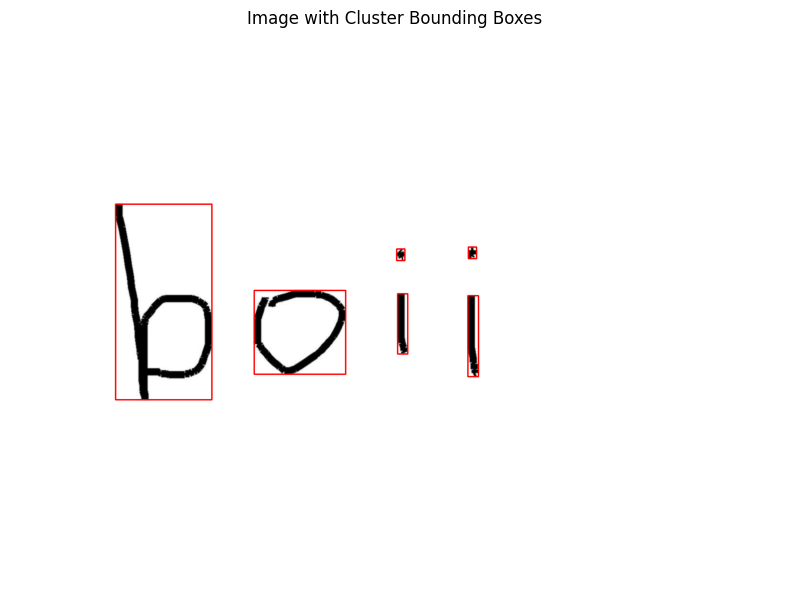

In [19]:
plt.figure(figsize=(10, 10 * image.shape[0] / image.shape[1]))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("Image with Cluster Bounding Boxes")
plt.axis('off')
plt.show()

In [20]:
counts = np.array(list(y_counts.values()))

ys = np.array(list(y_counts.keys()))

avg_y = np.average(ys, weights=counts)
print(avg_y)

604.9560585365854


In [21]:
plt.figure(figsize=(fig_width, fig_height))
plt.imshow(image, extent=[0, image.shape[1], image.shape[0], 0])
plt.axhline(avg_y, color='green', linestyle='-', linewidth=2, label=f'Avg Y = {avg_y:.1f}')
plt.legend()
plt.show()

In [22]:
# Build point-to-cluster map
point_to_cluster = {}
cluster_points_sets = []
for idx, cluster in enumerate(formatted_clusters):
    s = set(cluster)
    cluster_points_sets.append(s)
    for pt in cluster:
        point_to_cluster[pt] = idx

# Build adjacency map using avg_y as threshold
adjacency = defaultdict(set)
y_threshold = avg_y

print(f"Using average y-threshold: {y_threshold:.1f}")

for idx, cluster in enumerate(formatted_clusters):
    for (x, y) in cluster:
        if y < y_threshold:  # Only look upward from points below threshold
            for ny in range(y - 1, -1, -1):  # move upward
                pt = (x, ny)
                if pt in point_to_cluster:
                    other_idx = point_to_cluster[pt]
                    if other_idx != idx:
                        adjacency[idx].add(other_idx)
                        adjacency[other_idx].add(idx)
                    break

# Merge connected clusters
visited = set()
merged_clusters_dict = {}
merged_id = 0

for idx in range(len(formatted_clusters)):
    if idx in visited:
        continue

    # BFS to find connected cluster group
    q = deque([idx])
    merged_indices = set()

    while q:
        current = q.popleft()
        if current in visited:
            continue
        visited.add(current)
        merged_indices.add(current)
        q.extend(adjacency[current] - visited)

    # Combine points from all merged clusters
    merged_points = []
    for m_idx in merged_indices:
        merged_points.extend(formatted_clusters[m_idx])

    merged_clusters_dict[np.int64(merged_id)] = np.array(merged_points)
    merged_id += 1

Using average y-threshold: 605.0


In [23]:
unique_labels = list(merged_clusters_dict.keys())
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(fig_width, fig_height))
for k, col in zip(unique_labels, colors):
    col = list(col)
    xy = merged_clusters_dict[k]
    plt.scatter(xy[:, 0], xy[:, 1], color=tuple(col), label=f'Merged Cluster {k}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Clusters Merged Using Y-Threshold: {y_threshold:.1f}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
merged_clusters_dict

{np.int64(0): array([[219, 359],
        [220, 359],
        [221, 359],
        ...,
        [285, 765],
        [286, 765],
        [287, 765]]),
 np.int64(1): array([[958, 448],
        [959, 448],
        [960, 448],
        ...,
        [966, 716],
        [967, 716],
        [965, 717]]),
 np.int64(2): array([[813, 452],
        [812, 453],
        [813, 453],
        ...,
        [815, 669],
        [816, 669],
        [814, 670]]),
 np.int64(3): array([[592, 538],
        [594, 538],
        [595, 538],
        ...,
        [579, 712],
        [580, 712],
        [582, 712]])}

In [25]:
# Sort merged_clusters_dict by the minimum x-coordinate of each cluster
sorted_clusters = sorted(merged_clusters_dict.items(), key=lambda item: np.min(item[1][:, 0]))

# Rebuild the dictionary with new keys starting from 0
sorted_clusters_dict = {i: cluster for i, (_, cluster) in enumerate(sorted_clusters)}

In [26]:
np.set_printoptions(threshold=np.inf)

In [27]:
resized_boxes = {}

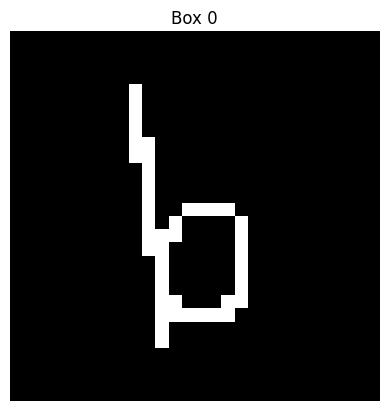

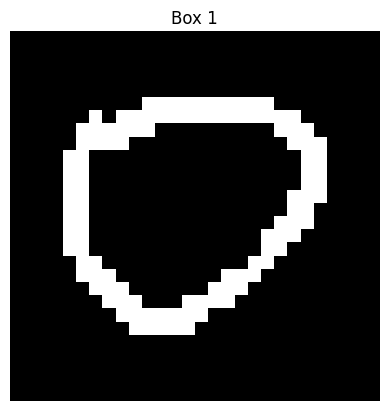

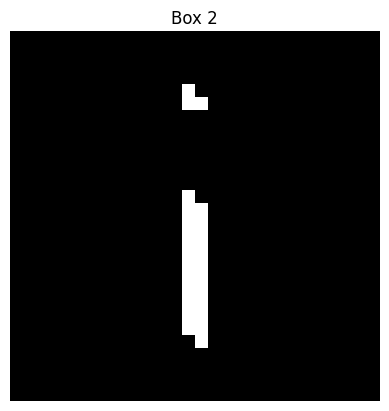

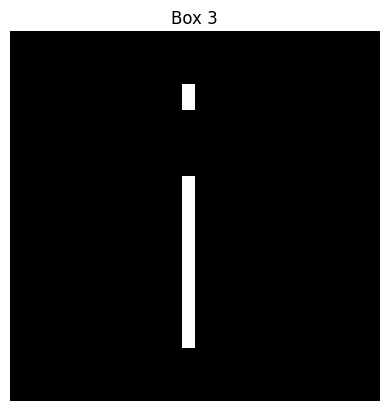

In [28]:
for key, cluster in sorted_clusters_dict.items():
    cluster = np.array(cluster)
    
    # Skip empty clusters
    if len(cluster) == 0:
        print(f"Warning: Cluster {key} is empty. Skipping.")
        continue

    xs, ys = cluster[:, 0], cluster[:, 1]

    # Define bounding box
    left, right = xs.min(), xs.max()
    top, bottom = ys.min(), ys.max()
    
    width = right - left + 1
    height = bottom - top + 1

    # Skip if width or height is zero (invalid box)
    if width <= 0 or height <= 0:
        print(f"Warning: Invalid dimensions for cluster {key}. Skipping.")
        continue

    # Create a white box (grayscale)
    box_img = np.full((height, width), 255, dtype=np.uint8)

    # Plot black pixels
    for x, y in cluster:
        box_x = x - left
        box_y = y - top
        box_img[box_y, box_x] = 0

    # Convert to RGB
    image = cv2.cvtColor(box_img, cv2.COLOR_GRAY2RGB)

    # Resize while maintaining aspect ratio
    target_size = 20
    h, w = image.shape[:2]
    
    # Avoid division by zero if max(h, w) == 0
    max_dim = max(h, w)
    if max_dim == 0:
        print(f"Warning: Zero-sized image in cluster {key}. Skipping.")
        continue

    scale = target_size / max_dim
    new_w = max(1, int(w * scale))  # Ensure at least 1 pixel
    new_h = max(1, int(h * scale))  # Ensure at least 1 pixel

    resized_img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Convert to grayscale and threshold to remove interpolation artifacts
    gray_resized = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
    _, binary_resized = cv2.threshold(gray_resized, 200, 255, cv2.THRESH_BINARY)

    # Convert back to RGB to paste on canvas
    resized_img_bw = cv2.cvtColor(binary_resized, cv2.COLOR_GRAY2RGB)

    # Create a white 28x28 canvas
    canvas = np.full((28, 28, 3), 255, dtype=np.uint8)

    # Center the resized image on the canvas
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img_bw

    # Invert for MNIST-style black background
    inverted_canvas = cv2.bitwise_not(canvas)

    # Store the result
    resized_boxes[key] = inverted_canvas

    # Display
    plt.imshow(inverted_canvas, cmap='gray')
    plt.title(f"Box {key}")
    plt.axis('off')
    plt.show()

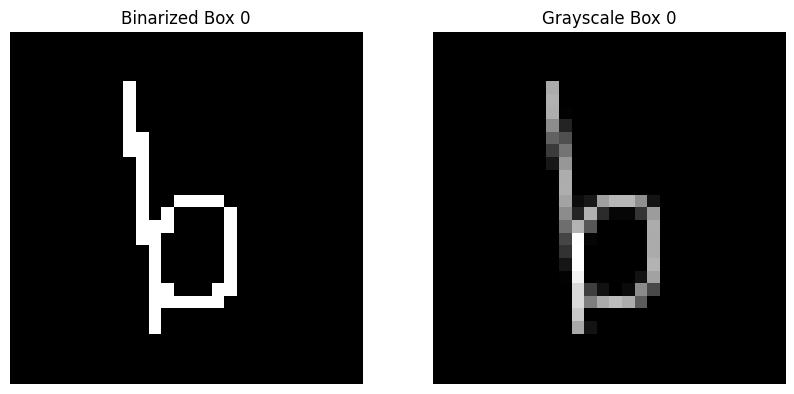

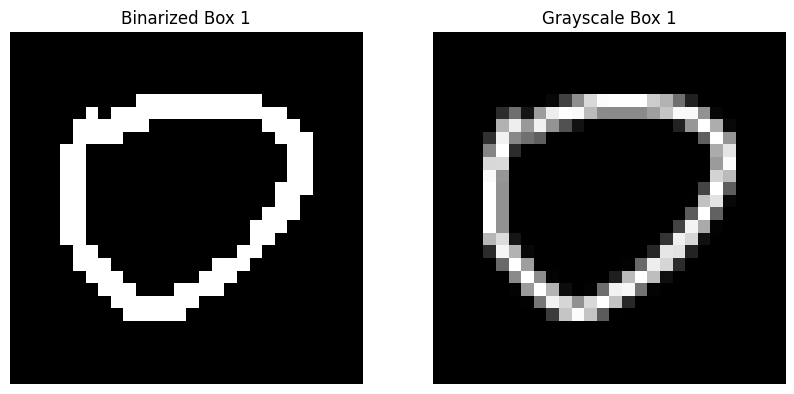

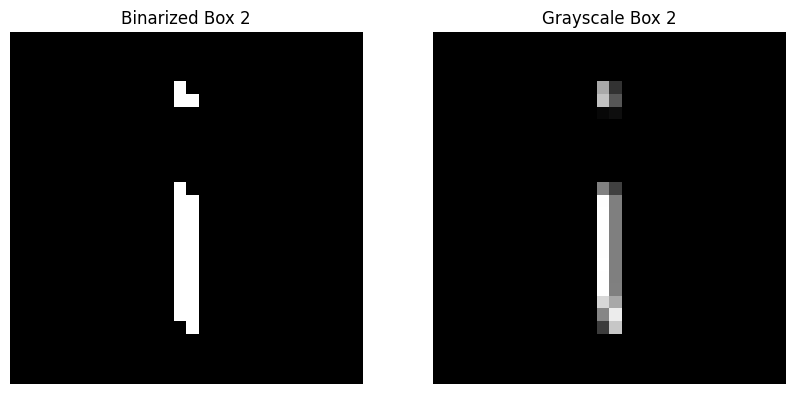

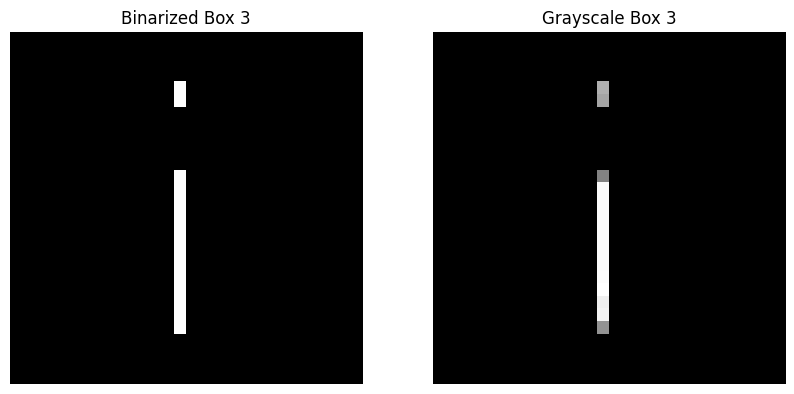

In [29]:
# Create or clear output directories
output_dirs = ['output_binarized', 'output_grayscale']
for dir_path in output_dirs:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)  # Remove directory and all its contents
    os.makedirs(dir_path, exist_ok=True)

resized_boxes = {}

for key, cluster in sorted_clusters_dict.items():
    cluster = np.array(cluster)
    
    # Skip empty clusters
    if len(cluster) == 0:
        print(f"Warning: Cluster {key} is empty. Skipping.")
        continue

    xs, ys = cluster[:, 0], cluster[:, 1]

    # Define bounding box
    left, right = xs.min(), xs.max()
    top, bottom = ys.min(), ys.max()
    
    width = right - left + 1
    height = bottom - top + 1

    # Skip if width or height is zero (invalid box)
    if width <= 0 or height <= 0:
        print(f"Warning: Invalid dimensions for cluster {key}. Skipping.")
        continue

    # Create a white box (grayscale)
    box_img = np.full((height, width), 255, dtype=np.uint8)

    # Plot black pixels
    for x, y in cluster:
        box_x = x - left
        box_y = y - top
        box_img[box_y, box_x] = 0

    # Convert to RGB
    image = cv2.cvtColor(box_img, cv2.COLOR_GRAY2RGB)

    # Resize while maintaining aspect ratio
    target_size = 20
    h, w = image.shape[:2]
    
    # Avoid division by zero if max(h, w) == 0
    max_dim = max(h, w)
    if max_dim == 0:
        print(f"Warning: Zero-sized image in cluster {key}. Skipping.")
        continue

    scale = target_size / max_dim
    new_w = max(1, int(w * scale))  # Ensure at least 1 pixel
    new_h = max(1, int(h * scale))  # Ensure at least 1 pixel

    resized_img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create grayscale version before binarization
    grayscale_resized = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)

    # Create binarized version
    _, binary_resized = cv2.threshold(grayscale_resized, 200, 255, cv2.THRESH_BINARY)

    # Create a white 28x28 canvas for both versions
    canvas_binary = np.full((28, 28), 255, dtype=np.uint8)
    canvas_grayscale = np.full((28, 28), 255, dtype=np.uint8)

    # Center the images on their respective canvases
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    
    canvas_binary[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = binary_resized
    canvas_grayscale[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = grayscale_resized

    # Invert both versions for MNIST-style black background
    inverted_binary = cv2.bitwise_not(canvas_binary)
    inverted_grayscale = cv2.bitwise_not(canvas_grayscale)

    # Save both versions
    cv2.imwrite(f'output_binarized/box_{key}.png', inverted_binary)
    cv2.imwrite(f'output_grayscale/box_{key}.png', inverted_grayscale)

    # Store the binary version for further processing (if needed)
    resized_boxes[key] = inverted_binary

    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(inverted_binary, cmap='gray')
    ax1.set_title(f"Binarized Box {key}")
    ax1.axis('off')
    
    ax2.imshow(inverted_grayscale, cmap='gray')
    ax2.set_title(f"Grayscale Box {key}")
    ax2.axis('off')
    
    plt.show()

In [30]:
DICTIONARY_FOR_NN = resized_boxes

In [31]:
# Define output folder
output_folder = "new_img"

# Create the folder if it doesn't exist, or clear it if it does
if os.path.exists(output_folder):
    # Remove all files in the folder
    for filename in os.listdir(output_folder):
        file_path = os.path.join(output_folder, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
else:
    os.makedirs(output_folder)

# Save each image in the dictionary to the folder
for key, image in DICTIONARY_FOR_NN.items():
    file_path = os.path.join(output_folder, f"image_{key}.png")
    cv2.imwrite(file_path, image)
    print(f"Saved {file_path}")

Saved new_img/image_0.png
Saved new_img/image_1.png
Saved new_img/image_2.png
Saved new_img/image_3.png


In [32]:
DROPOUT = 0.3

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)  # Input: 1 channel (grayscale)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p=DROPOUT)

        # Calculate flattened size correctly:
        # Input: 28x28
        # After conv1 (kernel=5, no padding): 28-5+1 = 24x24
        # After maxpool (kernel=2): 12x12
        # After conv2 (kernel=5): 12-5+1 = 8x8
        # After maxpool (kernel=2): 4x4
        self.flattened_size = 32 * 4 * 4  # 32 channels * 4x4 spatial dim

        # Classification head
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc1_drop = nn.Dropout(p=DROPOUT)
        self.fc2 = nn.Linear(128, 26)  # 26 classes for A-Z

    def forward(self, x):
        # Input shape: [batch, 1, 28, 28]

        # Conv1 -> BN -> ReLU -> MaxPool
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), kernel_size=2))  # [B, 16, 12, 12]

        # Conv2 -> BN -> Dropout -> ReLU -> MaxPool
        x = F.relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), kernel_size=2))  # [B, 32, 4, 4]

        # Flatten
        x = x.view(-1, self.flattened_size)

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [34]:
# model = CNN()

# Load the saved state dictionary
# model_path = 'models/emnist_cnn_model.pth'

# Load the saved state dictionary
# model.load_state_dict(torch.load(model_path, weights_only=True))

# Set the model to evaluation mode
# model.eval()

In [47]:
model_path = 'models/emnist_cnn_model.pth'

In [48]:
# Recreate the model architecture
loaded_model = CNN()

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
loaded_model.eval()

/var/folders/kt/1z0_7z79269b6p7bdrjn3m340000gn/T/ipykernel_3865/2585001405.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

In [49]:
class_names = [chr(ord('A') + i) for i in range(26)]

In [50]:
def predict_letters_from_directory(directory_path, model, class_names):
    """
    Predicts letters for all PNG images in the given directory and combines them into a string.

    Args:
        directory_path (str): Path to the directory containing PNG images.
        model (torch.nn.Module): Trained PyTorch model.
        class_names (list): List mapping class indices to letters (0='A', 1='B', etc.)

    Returns:
        str: Combined string of predicted letters from all images.
        list: List of tuples containing (image_path, predicted_letter, confidence) for each image.
    """
    # Get all PNG files in the directory
    image_files = [f for f in os.listdir(directory_path) if f.lower().endswith('.png')]
    image_files.sort()  # Sort to maintain order
    
    predicted_string = ""
    predictions = []
    
    for image_file in image_files:
        image_path = os.path.join(directory_path, image_file)
        
        # Load and process the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = image.resize((28, 28))
        image_array = np.array(image)
        
        image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, prediction = torch.max(probabilities, dim=1)
            confidence = confidence.item()
            prediction = prediction.item()
        
        # Map the prediction to a letter
        predicted_letter = class_names[prediction] if prediction < len(class_names) else "?"
        predicted_string += predicted_letter
        
        # Store individual prediction info
        predictions.append((image_path, predicted_letter, confidence))
        
        # Visualize the prediction
        plt.figure()
        plt.imshow(image_array, cmap='gray')  # Transpose back for display
        plt.title(f"Predicted: {predicted_letter}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()
    
    return predicted_string, predictions

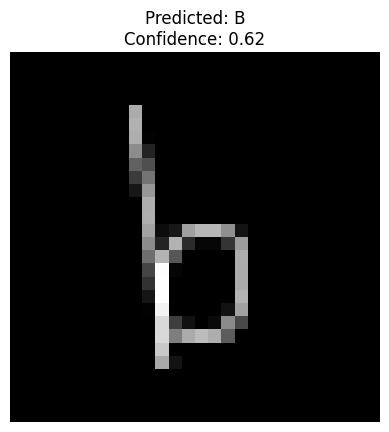

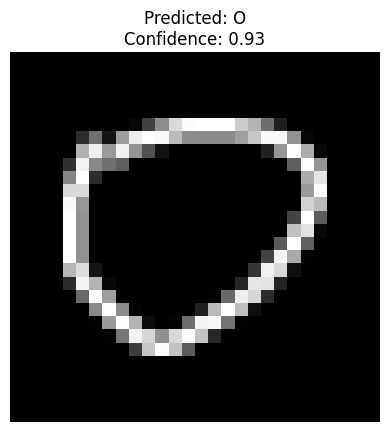

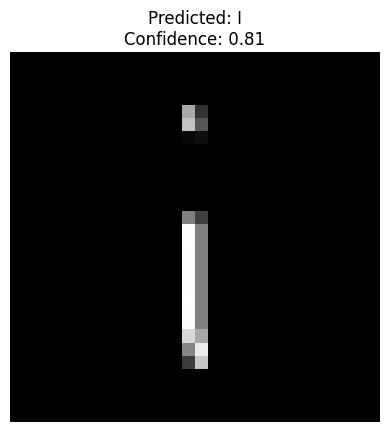

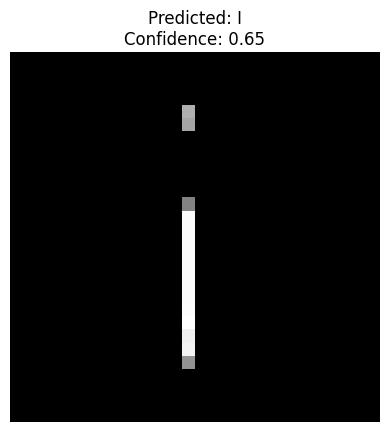

Combined predictions: BOII

Individual predictions:
box_0.png: B (confidence: 0.62)
box_1.png: O (confidence: 0.93)
box_2.png: I (confidence: 0.81)
box_3.png: I (confidence: 0.65)


In [53]:
directory_path = "output_grayscale//" 
predicted_string, individual_predictions = predict_letters_from_directory(directory_path, loaded_model, class_names)

print(f"Combined predictions: {predicted_string}")
print("\nIndividual predictions:")
for img_path, letter, conf in individual_predictions:
    print(f"{os.path.basename(img_path)}: {letter} (confidence: {conf:.2f})")

In [54]:
print(predicted_string.lower().capitalize())

Boii
